## Import code

In [1]:
from bayeslr.bayeslr import *

from scipy.stats import linregress, norm, pearsonr
import matplotlib.pyplot as plt 
import pandas as pd

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':2,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

## Model definition

Want to predict a single output $y \in \mathbb{R}$ given a vector of features $\mathbf{x} \in \mathbb{R}^d$ 

By defining a basis function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^m$, the model predicts $y$ as a linear combination of potentially non-linear functions of $\mathbf{x}$, weighted by regression coefficients $\mathbf{w} \in \mathbb{R}^m$.  

$$
y = \mathbf{w}^T \phi (\mathbf{x}) + \varepsilon
$$

The model assumes that measurements are corrupted by zero-mean Gaussian noise with precision $\beta$, 


$$
\varepsilon \sim \mathcal{N}(\varepsilon | 0, \beta^{-1})
$$

# Import data

In [2]:
df = pd.read_csv("data/Regressionmodel_formatted_EXP004.csv")
df

,Condition,Replicates,Day,CD,BT,BU,PV,CA,CH,CS,DP,EL,PC,CD abs end
0,CD-BT_1,1,35,1,1,0,0,0,0,0,0,0,0,0.000355
1,CD-BT_2,2,35,1,1,0,0,0,0,0,0,0,0,0.000721
2,CD-BT_3,3,35,1,1,0,0,0,0,0,0,0,0,0.000173
3,CD-BU_1,1,35,1,0,1,0,0,0,0,0,0,0,0.422873
4,CD-BU_2,2,35,1,0,1,0,0,0,0,0,0,0,0.342751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,CD-PC-CH_2,2,35,1,0,0,0,0,1,0,0,0,1,0.000000
89,CD-PC-CH_3,3,35,1,0,0,0,0,1,0,0,0,1,0.000000
90,CD-PC-CS_1,1,14,1,0,0,0,0,0,1,0,0,1,0.000000
91,CD-PC-EL_2,2,35,1,0,0,0,0,0,0,0,1,1,0.092879


In [3]:
# exclude CD since it's always there (not informative)
features = df.columns.values[4:-1]
features

# target is CD at end
target = 'CD abs end'

In [4]:
X = df[features].values
y_true = df[target].values

In [5]:
# define basis function that accounts for all pairwise interactions
@jit
def basis(x):
    # return upper triangular elements of outerproduct 
    cross_terms = jnp.outer(x, x)[jnp.triu_indices(len(x), k=1)]
    return jnp.concatenate((jnp.array([1.]), x, cross_terms))
batch_basis = jit(vmap(basis))

# add cross terms to X 
X_basis = batch_basis(X)

In [6]:
# # scale data
# y_mean = np.mean(y_true)
# y_stdv = np.std(y_true)
# y_scale = (y_true - y_mean) / y_stdv

In [7]:
blr = LR()
blr.fit(X_basis, y_true)

Evidence -29.798
Evidence 22.318
Evidence 67.046
Evidence 102.599
Evidence 125.725
Evidence 137.476
Evidence 142.685
Evidence 145.079
Evidence 146.312
Evidence 147.013
Evidence 147.439
Evidence 147.711
Evidence 147.892
Evidence 148.014
Pass count  1


In [8]:
y_pred, y_std = blr.predict(X_basis)
# y_pred = np.clip(y_pred * y_stdv + y_mean, 0., np.inf)
y_pred = np.clip(y_pred, 0., np.inf)

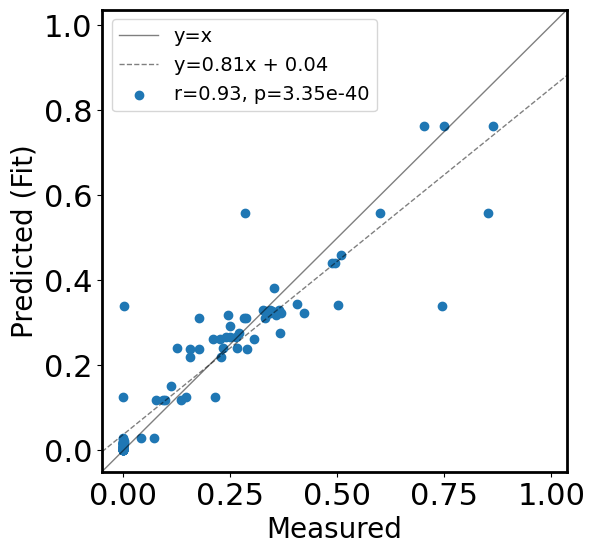

In [9]:
plt.figure(figsize=(6,6))

m, b, rval, pval, _ = linregress(y_true, y_pred)

plt.plot([-1., 1.5*max(y_true)], [-1., 1.5*max(y_true)], linewidth=1, label='y=x', c='k', alpha=.5)
x = np.linspace(-1., 1.5*max(y_true))
y = m*x + b
plt.plot(x, y, linewidth=1, linestyle='--', c='k', alpha=.5,
         label=f"y={m:.2f}x + {b:.2f}")
plt.scatter(y_true, y_pred, label=f"r={rval:.2f}, p={pval:.2e}")
plt.legend(fontsize=14)

plt.xlim([-.05, 1.2*max(y_true)])
plt.ylim([-.05, 1.2*max(y_true)])

plt.xlabel("Measured")
plt.ylabel("Predicted (Fit)")
plt.savefig("figures/LR/LR_FIT.pdf")
plt.show()

In [10]:
features

array(['BT', 'BU', 'PV', 'CA', 'CH', 'CS', 'DP', 'EL', 'PC'], dtype=object)

In [11]:
blr.predict(batch_basis(df.iloc[np.sum(df[['BT' , 'PC']].values, 1)==2][features].values))

(Array([-0.01460078, -0.01460078], dtype=float32),
 array([0.11438457, 0.11438457], dtype=float32))

In [12]:
blr.params[batch_basis(df.iloc[np.sum(df[['BT' , 'PC']].values, 1)==2][features].values)[0] > 0]

Array([ 0.32988328, -0.31293353, -0.31479654,  0.283246  ], dtype=float32)

In [13]:
# get feature names
ftr_names = np.array(np.zeros([len(features), len(features)]), str)
for i,fi in enumerate(features):
    for j,fj in enumerate(features):
        ftr_names[i,j] = fi+" x "+fj
ftr_names = np.concatenate([['Intercept'], features, ftr_names[jnp.triu_indices(len(features), k=1)]])

In [14]:
ftr_names[batch_basis(df.iloc[np.sum(df[['BT' , 'PC']].values, 1)==2][features].values)[0] > 0]

array(['Intercept', 'BT', 'PC', 'BT x PC'], dtype=object)

In [15]:
# parameter mean and std dev.
mu = blr.params
s = np.sqrt(np.diag(blr.Ainv))

walds = mu/s
wald_p_vals = 2.*norm.cdf(-np.abs(walds))

In [16]:
# save parameters
param_df = pd.DataFrame()
param_df['Feature'] = ftr_names
param_df["Mean"] = mu
param_df["Stdv"] = s
param_df["P-val"] = wald_p_vals
param_df.to_csv("params/LR/LR_params.csv", index=False)

In [17]:
param_df

,Feature,Mean,Stdv,P-val
0,Intercept,0.329883,0.023942,3.423239e-43
1,BT,-0.312934,0.029888,1.185531e-25
2,BU,-0.006488,0.021680,7.647342e-01
3,PV,0.010903,0.024577,6.573090e-01
4,CA,0.000980,0.020124,9.611631e-01
5,CH,-0.006415,0.020279,7.517623e-01
6,CS,-0.018446,0.024124,4.444793e-01
7,DP,-0.052694,0.029981,7.881552e-02
8,EL,0.110847,0.036340,2.286188e-03
9,PC,-0.314797,0.033701,9.543488e-21


In [18]:
len(ftr_names[wald_p_vals<.05])

12

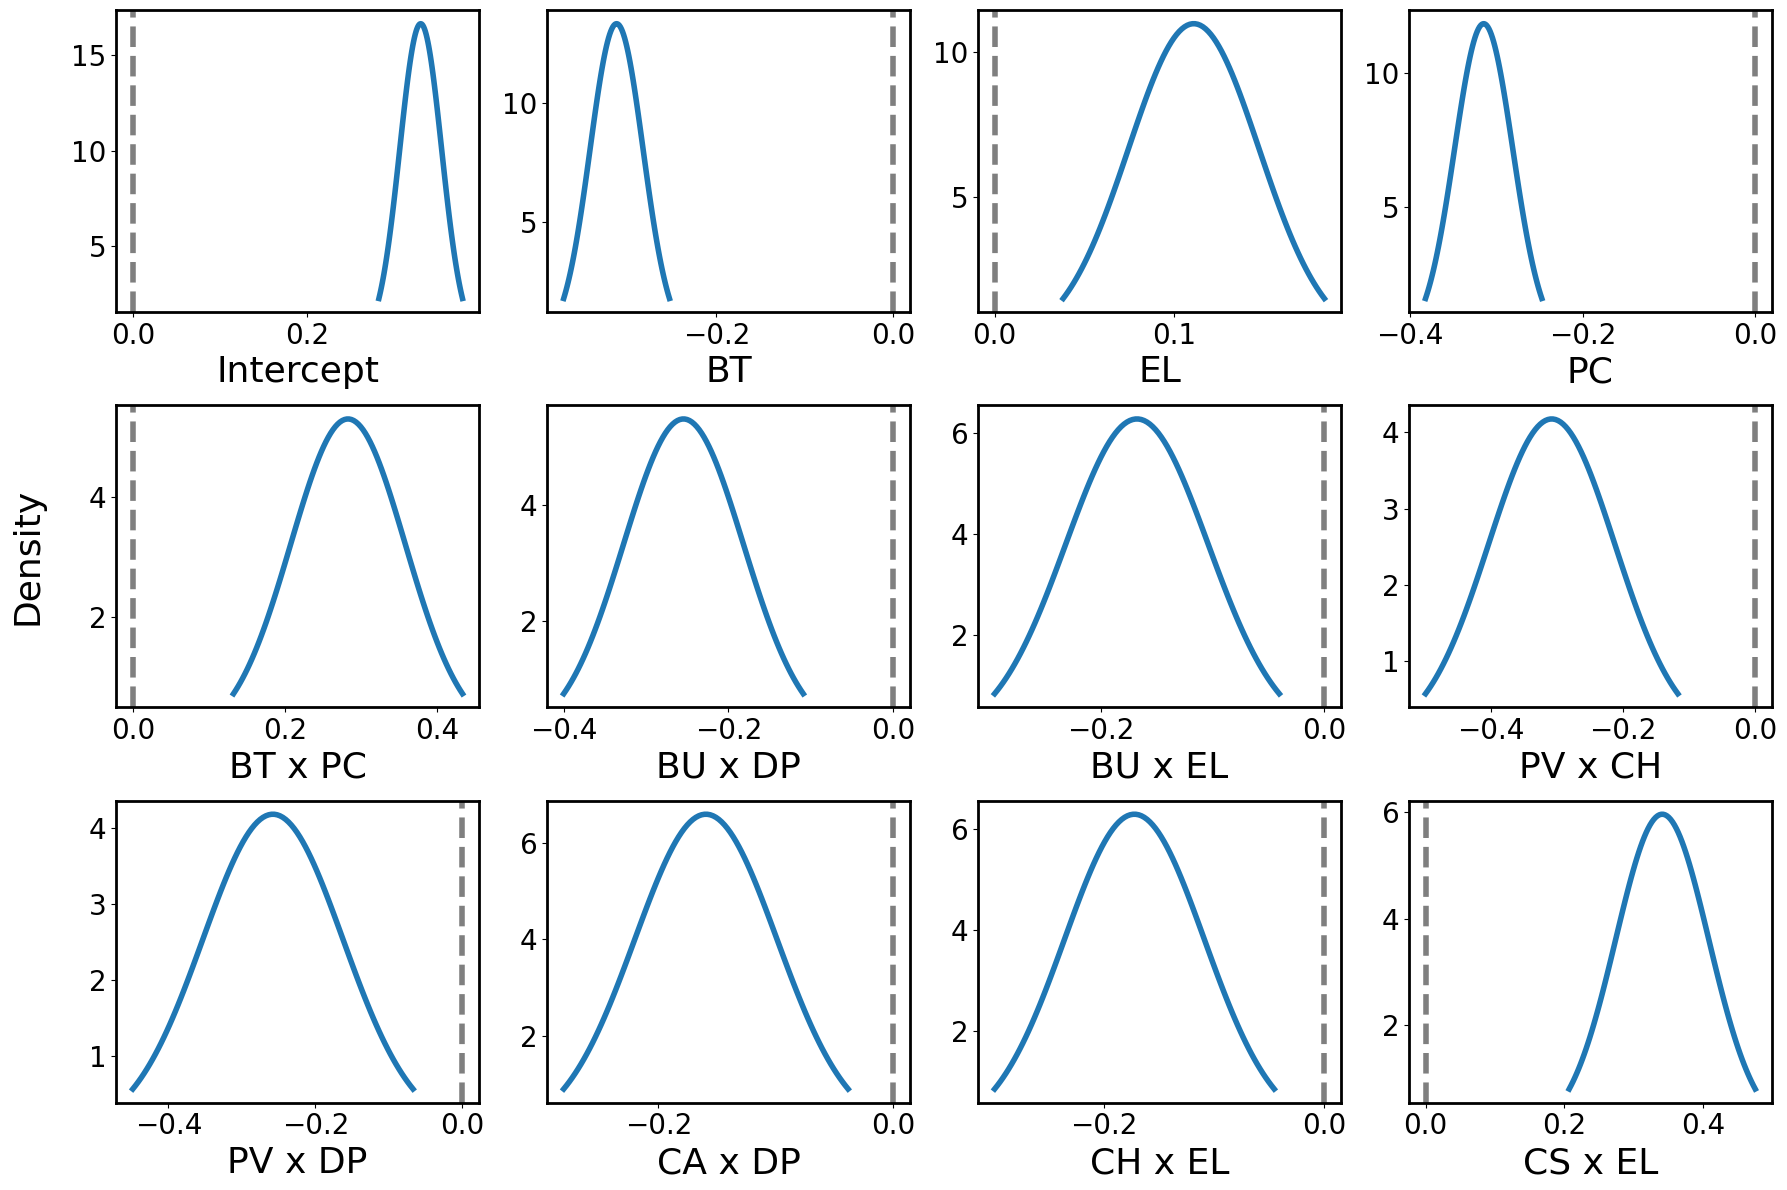

In [20]:
plt.figure(figsize=(18, 12))

for i, (ftr, mu_i, s_i) in enumerate(zip(ftr_names[wald_p_vals<.05], mu[wald_p_vals<.05], s[wald_p_vals<.05])):    

    # Calculate the PDF values using the normal distribution
    plt.subplot(3, 4, i+1)
    x = np.linspace(mu_i - 2*s_i, mu_i + 2*s_i, 100)
    pdf = norm.pdf(x, loc=mu_i, scale=s_i)

    # Plot the Gaussian PDF
    plt.plot(x, pdf, label=f"$\mu$: {mu_i:.2f}\n$\sigma$: {s_i:.2f}")
    plt.axvline(x=0, linestyle='--', c='k', alpha=.5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if i == 4:
        plt.ylabel("Density\n", fontsize=26)
    plt.xlabel(ftr, fontsize=26)
    
plt.tight_layout()
plt.savefig("figures/LR/LR_posterior.pdf")
plt.show()